In [1]:
%matplotlib inline

<h1>Libraries import</h1>

In [2]:
import glob
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import decomposition

from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from sklearn import metrics

import matplotlib.pyplot as plt


<h1>Data pre-processing</h1>

In [3]:
bcClass0I = []
bcClass1I = []
for f in glob.iglob("./breast_cancer_histopathology_images/0/*.png"):
    bcClass0I.append(np.asarray(Image.open(f).resize((64,64)), dtype=np.float32))

bcClass1 = []
for f in glob.iglob("./breast_cancer_histopathology_images/1/*.png"):
    bcClass1I.append(np.asarray(Image.open(f).resize((64,64)), dtype=np.float32))

bcImagesI = bcClass0I + bcClass1I

bcClass0 = np.array(bcClass0I)
bcClass1 = np.array(bcClass1I)
bcImages = np.array(bcImagesI)
bcImages = bcImages/np.linalg.norm(bcImages)

class0 = [0]*bcClass0.shape[0]
class1 = [1]*bcClass1.shape[0]
target = np.array(class0 + class1)

reshaped = np.reshape(bcImages, (bcImages.shape[0], -1))

breast_cancer = {
    "data": reshaped,
    "images": bcImages,
    "target": target
}

<b>Shape of the datas, and their data types</b>

In [4]:
print("Number of breast_cancer image = ", breast_cancer["images"].shape[0])
print("breast_cancer image data type = ", type(breast_cancer["images"][0][0][0][0]))

Number of breast_cancer image =  2022
breast_cancer image data type =  <class 'numpy.float32'>


In [5]:
print("breast_cancer image shape = ", breast_cancer["images"].shape)

breast_cancer image shape =  (2022, 64, 64, 3)


In [6]:
print("breast_cancer data shape = ", breast_cancer["data"].shape)
print("breast_cancer target shape = ", breast_cancer["target"].shape)

breast_cancer data shape =  (2022, 12288)
breast_cancer target shape =  (2022,)


<b>Data types</b>

In [7]:
print("breast_cancer image data type = ", type(breast_cancer["images"][0][0][0][0]))
print("breast_cancer data, data type = ", type(breast_cancer["data"][0][0]))
print("breast_cancer target data type = ", type(breast_cancer["target"][0]))

breast_cancer image data type =  <class 'numpy.float32'>
breast_cancer data, data type =  <class 'numpy.float32'>
breast_cancer target data type =  <class 'numpy.int64'>


<b>Split train and test data</b>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
        breast_cancer["data"],
        breast_cancer["target"],
        test_size=0.25,
        random_state=42,
        shuffle=True,
        stratify=breast_cancer["target"])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train data shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test data shape", X_test.shape)
print("Test target shape", y_test.shape)

Train data shape (1516, 12288)
Train target shape (1516,)
Test data shape (506, 12288)
Test target shape (506,)


<b>Using PCA for dimensionality reduction </b> 

In [9]:
pca = decomposition.PCA(n_components=0.9, svd_solver="auto", whiten=True)
pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [10]:
print("PCA train data shape = ", X_train_pca.shape)
print("PCA test data shape", X_test_pca.shape)

PCA train data shape =  (1516, 353)
PCA test data shape (506, 353)


<h1>Model selection</h1>

In [11]:
param_grid = {
    "C": loguniform(1e3, 1e4),
    "gamma": loguniform(1e-4, 1e-1),
    "kernel": ["rbf"],
    "class_weight":["balanced"]
}
clf = RandomizedSearchCV(
    svm.SVC(),
    param_grid,
    n_iter=10
)
clf.fit(X_train_pca, y_train)

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe2f0a46fb0>,
                                        'class_weight': ['balanced'],
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe2f0a47d00>,
                                        'kernel': ['rbf']})

In [12]:
print("Best estimator found by randomized search:")
print(clf.best_estimator_)

Best estimator found by randomized search:
SVC(C=4184.88854880601, class_weight='balanced', gamma=0.0051665798490559385)


<h1>Train </h1>
<b>Using K-SVM with rbf kernel and the calculated hyperparameters. </b>

In [13]:
clf1 = svm.SVC(C=4184.88854880601, class_weight='balanced', gamma=0.0051665798490559385, kernel= "rbf")
clf1.fit(X_train_pca, y_train)

SVC(C=4184.88854880601, class_weight='balanced', gamma=0.0051665798490559385)

<h1>Model Evaluation</h1>

<b>Score for the Train data</b>

In [14]:
trainScore = clf1.score(X_train_pca, y_train)
print("Train score = ", trainScore)

Train score =  1.0


<b>Score for the Test data</b>

In [15]:
testScore = clf1.score(X_test_pca, y_test)
print("Test score = ", testScore)

Test score =  0.8102766798418972


<b>Classification Report on prediction </b>

In [16]:
y_pred = clf1.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.70      0.75       203
           1       0.81      0.88      0.85       303

    accuracy                           0.81       506
   macro avg       0.81      0.79      0.80       506
weighted avg       0.81      0.81      0.81       506



<b>Confusion Matrix</b>

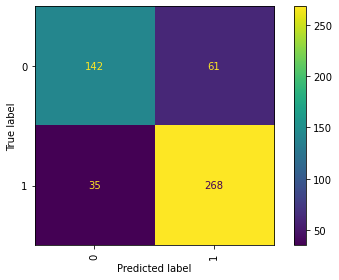

In [17]:
metrics.ConfusionMatrixDisplay.from_estimator(
    clf1, X_test_pca, y_test, display_labels=[0,1], xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()